This notebook describes how to scale the data in order to be represented ONLY as unsigned int values.

Imports

In [1]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
import h5py
from multiprocess import Pool
from tqdm import tqdm
import math

import matplotlib
matplotlib.style.use('seaborn')

import sys
sys.path.append('../')
import nonuniform_quantization

File info (modify according to your environment and dataset)

In [2]:
file_path = '/sdf/home/b/berthie/tmox42619_data/h5files/hits.tmox42619.run135.h5'
good_ports = ['port_0','port_1','port_4','port_5','port_12','port_13','port_14','port_15']

Input data

In [3]:
f = h5py.File(file_path, 'r')

raw_tofs = []
for port in good_ports:
    temp = np.asarray(f[port]['tofs'][1:])
    raw_tofs.append(temp-temp.min())      # I subtract the minimum value so it shifts the spectrum "left"

Quantizer (Choose "n", the number of bit for the quantizer)

In [4]:
n=5 
Q = nonuniform_quantization.quantizer(Nb_bits=n)

Quantizer Training 

In [5]:
with Pool(16) as p:
    pool_outputs = list(
        tqdm(
            p.imap(Q.training,
                   raw_tofs),
            total=len(good_ports)
        )
    ) 

tofs_QLvl = []
for port in range(len(good_ports)):
    tofs_QLvl.append(pool_outputs[port][:])

100%|██████████| 8/8 [00:28<00:00,  3.54s/it]


Quantization

In [6]:
quantized_tofs_cluster_assignments = []
quantized_tofs = []
for port in tqdm(range(len(good_ports))):
    quantized_tofs_temp, quantized_tofs_cluster_assignments_temp = Q.quantization(raw_tofs[port], tofs_QLvl[port], return_cluster_assignments=True)
    quantized_tofs_cluster_assignments.append(quantized_tofs_cluster_assignments_temp)
    quantized_tofs.append(quantized_tofs_temp)

100%|██████████| 8/8 [00:00<00:00, 242.89it/s]


Scaling

This next cell iteratively find the unity resolution we need to represente all possible TOF values over all the dynamic range as a integer value.

In [7]:
raw_tofs_index = []
quantized_tofs_index = []
quantized_tofs_index_cluster_assignments = []

for port in tqdm(range(len(good_ports))):
    all_samples =  raw_tofs[port]
    max_value = all_samples.max()

    b=1
    all_samples_normalized = all_samples/max_value
    all_samples_normalized_scaled = np.floor(all_samples_normalized*(2**b)).astype(int)

    while(len(np.unique(all_samples)) != len(np.unique(all_samples_normalized_scaled))):
        b+=1
        all_samples_normalized_scaled = np.floor(all_samples_normalized*(2**b)).astype(int)

    raw_tofs_index_temp = all_samples_normalized_scaled

    assignment_pts = tofs_QLvl[port]
    assignment_pts_normalized = assignment_pts/max_value
    assignment_pts_normalized_scaled = np.floor(assignment_pts_normalized*(2**b)).astype(int)
    assignment_pts_index = assignment_pts_normalized_scaled

    # We can then quantized the same way, but now all values are integer. Note that the cluster assignments are exactly the same as when using the floating values.
    quantized_tofs_index_temp, quantized_tofs_index_cluster_assignments_temp = Q.quantization(raw_tofs_index_temp, assignment_pts_index, return_cluster_assignments = True)

    raw_tofs_index.append(raw_tofs_index_temp)
    quantized_tofs_index.append(quantized_tofs_index_temp)
    quantized_tofs_index_cluster_assignments.append(quantized_tofs_index_cluster_assignments_temp)


100%|██████████| 8/8 [00:09<00:00,  1.13s/it]


We see that the relative spectrum is the same, but with a 1 to 1 mapping to a integer representation. 

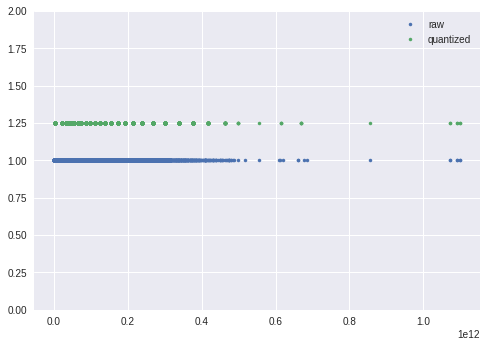

In [11]:
port=1
plt.plot(raw_tofs_index[port],np.ones_like(raw_tofs_index[port]) ,'.', label='raw')
plt.plot(quantized_tofs_index[port],np.ones_like(quantized_tofs_index[port]) + 0.25 ,'.', label='quantized')
plt.ylim([0,2])
plt.legend()
plt.show()


Making heatmaps/sinograms

In [9]:
Nb_QLvl = int(2**n)

hist = np.zeros((len(f[good_ports[0]]['addresses']), len(good_ports), Nb_QLvl))

for port in tqdm(range(len(good_ports))):
    for ind, offset in enumerate(f[good_ports[port]]['addresses']):   
        nhits = f[good_ports[port]]['nedges'][ind]
        temp = quantized_tofs_index_cluster_assignments[port][offset:offset+nhits]
        for i in range(len(temp)):
            hist[ind ,port, temp[i]] += 1


100%|██████████| 8/8 [01:34<00:00, 11.78s/it]


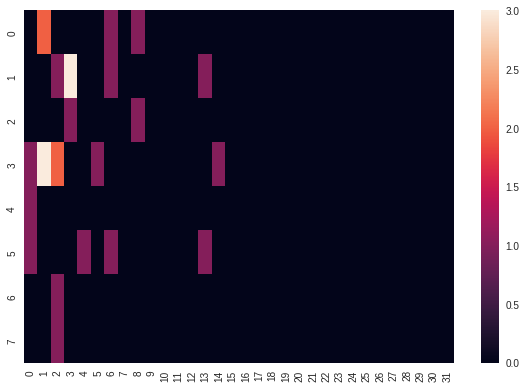

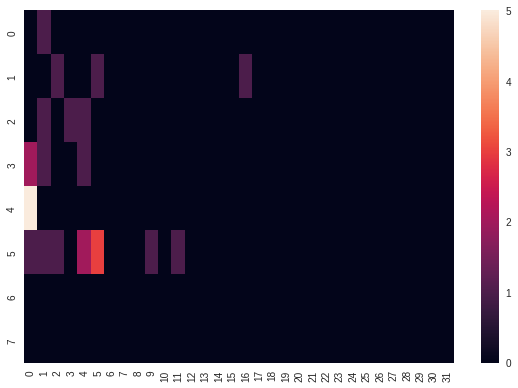

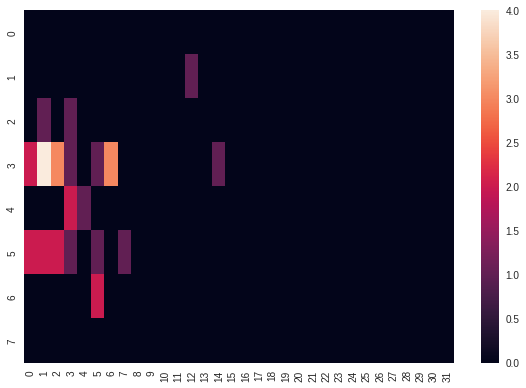

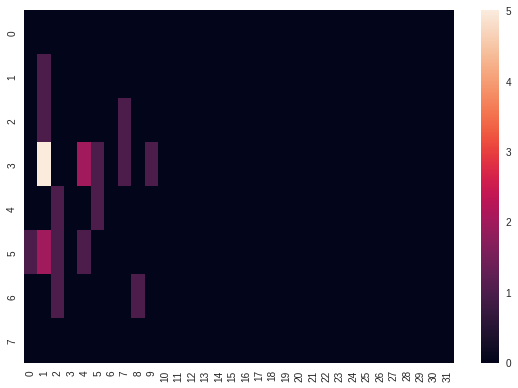

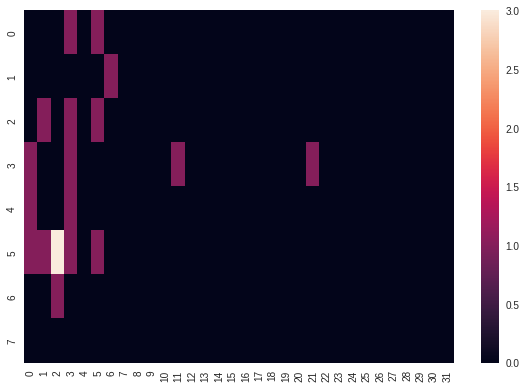

In [10]:
import seaborn as sns

for i in range(5):
    ax = sns.heatmap(hist[i])
    # plt.xlim([0,100])
    plt.tight_layout()
    plt.show()



 * MIT License
 *
 * Copyright (c) 2022 SLAC National Accelerator Laboratory
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in all
 * copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
 * SOFTWARE.
 *
 * Authors : Berthié Gouin-Ferland
 * Last update : 2022-12-06
 *
 * Description : This notebook describes how to scale the data in order to be represented ONLY as unsigned int values.
